In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
from ipywidgets import widgets
from sklearn import preprocessing
from tensorflow import keras 
from tensorflow.keras import layers, regularizers,Model, utils
%matplotlib inline 
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.callbacks import TensorBoard
from datetime import time
import plotly.express as px

In [3]:
dataPath_input = widgets.Text(description="Path to CSV:", value="outputs/")
dataPath_input

Text(value='outputs/', description='Path to CSV:')

In [4]:
dataByLocation = pd.read_csv(dataPath_input.value)
data = dataByLocation.drop(columns=["Time", "Longitude", "Latitude"])

In [5]:
data = dataByLocation.drop(columns=["Time", "Longitude", "Latitude"])
data

Speed  LatAcceleration  LongAcceleration  SteerTorque  SteerRate  \
0      75.155687      -501.740000          0.013309          0.0   0.000000   
1      75.260991      -501.740000          0.000000          0.0  -0.967652   
2      75.227563      -501.740000          0.000000          0.0  -3.648693   
3      75.467328      -501.720768          0.112396          0.0   0.000000   
4      75.500000      -501.740000          0.103073          0.0   0.000000   
...          ...              ...               ...          ...        ...   
37853   0.000000      -501.740000          0.000000          0.0   0.000000   
37854   0.000000      -501.733100          0.000000          0.0   0.000000   
37855   0.000000      -501.740000          0.000000          0.0   0.000000   
37856   0.000000      -501.740000          0.000000          0.0   0.000000   
37857   0.000000      -501.740000          0.000000          0.0   0.000000   

       SteerAngle  FLWheelSpeed  FRWheelSpeed  RRWheelSpeed  RLWheelSpeed  
0        1.700000     75.159684     75.113947     74.932737     74.926684  
1        1.800000     75.006872     75.095745     75.014983     75.029818  
2        1.810812     75.262530     75.182388     74.810142     74.737943  
3        2.100000     75.521644     75.467706     75.129178     74.946233  
4        2.100000     75.536009     75.604389     75.237599     75.336790  
...           ...           ...           ...           ...           ...  
37853 -229.100000      0.000000      0.000000      0.000000      0.000000  
37854 -229.100000      0.000000      0.000000      0.000000      0.000000  
37855 -229.100000      0.000000      0.000000      0.000000      0.000000  
37856 -229.100000      0.000000      0.000000      0.000000      0.000000  
37857 -229.100000      0.000000      0.000000      0.000000      0.000000  

[37858 rows x 10 columns]

## Normalize Data

In [6]:
data = data.values[:]
min_max_scaler = preprocessing.MinMaxScaler()
data_normalized = min_max_scaler.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized)

## Window Data

In [7]:
features = ['Speed',
            'LatAcceleration',
            'LongAcceleration',
            'SteerTorque',
            'SteerRate',
            'SteerAngle',
            'FLWheelSpeed',
            'FRWheelSpeed',
            'RRWheelSpeed',
            'RLWheelSpeed']
data_df = data_normalized

In [8]:
sequenceLength = 5
stackedData, stackedLabels = np.array([]), np.array([])

stackedData = []

# split can_data into subsampled sequences
for i in range(len(data_df)-sequenceLength):
    stackedData.append(data_df[i:i+sequenceLength])
    
stackedData = np.array(stackedData)

## Generate Labels

In [9]:
data_normalized.shape

(37858, 10)

In [105]:
longitudeLabels = []
latitudeLabels = []

for i,window in enumerate(stackedData[:-1]):
    last = dataByLocation.iloc[i]
    lastLong = last.Longitude
    lastLat = last.Latitude
    cur = dataByLocation.iloc[i+5]
    curLong = cur.Longitude
    curLat = cur.Latitude
    
    longitudeLabels.append(curLong - lastLong)
    latitudeLabels.append(curLat - lastLat)

longitudeLabels = np.array(longitudeLabels)
latitudeLabels = np.array(latitudeLabels)

original = pd.DataFrame({"longDeltas": longitudeLabels, "latDeltas": latitudeLabels})

longMin = np.amin(longitudeLabels)
latMin = np.amin(latitudeLabels)
overallMin = min(longMin, latMin)
b = (-1)*overallMin

for i,val in enumerate(longitudeLabels):
    longitudeLabels[i] = val+b
for i,val in enumerate(latitudeLabels):
    latitudeLabels[i] = val+b
    
overallMax = max(np.amax(longitudeLabels),np.amax(latitudeLabels))
scalingFactor = 1/overallMax

for i,val in enumerate(longitudeLabels):
    longitudeLabels[i] = val*scalingFactor
for i,val in enumerate(latitudeLabels):
    latitudeLabels[i] = val*scalingFactor
    
def reverseNormalization(vals):
    return (vals/scalingFactor)-b
    
normalizedLabels = pd.DataFrame({"longDeltas": longitudeLabels, "latDeltas": latitudeLabels})
reverse = pd.DataFrame({"longDeltas": reverseNormalization(longitudeLabels), "latDeltas": reverseNormalization(latitudeLabels)})

longDeltas     latDeltas
count  37852.000000  37852.000000
mean       0.000005     -0.000032
std        0.000043      0.000044
min       -0.000122     -0.000130
25%        0.000000     -0.000080
50%        0.000000      0.000000
75%        0.000000      0.000000
max        0.000175      0.000084

In [11]:
trainingData = stackedData[:-1]
trainingData.shape

(37852, 5, 10)

## Build Neural Network

### MLP

In [65]:
#specify input dimensionality
numberOfSamples = trainingData.shape[0]
inputDimension = trainingData[0].shape[0]*trainingData[0].shape[1]
outputDimension = 1

#construct our neural network
hiddenLayerSizes = [inputDimension, 32, 16, 8, 4, 2]

#set up our input layer
inputLayer = layers.Input(shape=(inputDimension, ))

#set up our hidden layers
curLayer = 0
previousLayer = inputLayer
for curLayerSize in hiddenLayerSizes:
    previousLayer = layers.Dense(curLayerSize,
                                 activation='sigmoid', 
                                 name=str(curLayerSize)+'_hiddenLayer',
                                 kernel_regularizer=regularizers.L2(0.001)
                                )(previousLayer)
    
outputLayer = layers.Dense(outputDimension, activation='sigmoid')(previousLayer)

#compile our model
ourModel = Model(inputs=inputLayer, outputs=[outputLayer], name='longitude_mlp')
ourModel.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
    

In [67]:
#train the mlp
#initially we have(N, 28, 28); we want (N, 28*28)
trainingDataFlat = trainingData.reshape((-1, inputDimension))
ourModel.fit(trainingDataFlat, longitudeLabels, epochs=10)

Epoch 1/10
1183/1183 [==============================] - 1s 1ms/step - loss: 6.6062e-06 - root_mean_squared_error: 0.0026
Epoch 2/10
1183/1183 [==============================] - 1s 1ms/step - loss: 3.5375e-06 - root_mean_squared_error: 0.0019
Epoch 3/10
1183/1183 [==============================] - 2s 1ms/step - loss: 1.9176e-06 - root_mean_squared_error: 0.0014
Epoch 4/10
1183/1183 [==============================] - 1s 1ms/step - loss: 1.0485e-06 - root_mean_squared_error: 0.0010
Epoch 5/10
1183/1183 [==============================] - 1s 1ms/step - loss: 5.7714e-07 - root_mean_squared_error: 7.5965e-04
Epoch 6/10
1183/1183 [==============================] - 1s 1ms/step - loss: 3.1956e-07 - root_mean_squared_error: 5.6528e-04
Epoch 7/10
1183/1183 [==============================] - 2s 1ms/step - loss: 1.7814e-07 - root_mean_squared_error: 4.2206e-04
Epoch 8/10
1183/1183 [==============================] - 2s 1ms/step - loss: 1.0024e-07 - root_mean_squared_error: 3.1660e-04
Epoch 9/10
1183/

### CNN

In [111]:
trainingData.shape

(37851, 5, 10)

In [14]:
#specify input dimensionality
numberOfSamples = trainingData.shape[0]
inputDimension = trainingData[0].shape[0]*trainingData[0].shape[1]
outputDimension = 1

#construct our neural network
hiddenLayerSizes = [inputDimension, 32, 16, 8, 4, 2]

#set up our input layer
inputLayer = layers.Input(shape=(inputDimension, 1))

#set up our hidden layers
curLayer = 0
previousLayer = inputLayer
for curLayerSize in hiddenLayerSizes:
    previousLayer = layers.Conv1D(curLayerSize, 5,
                                  activation='sigmoid',
                                  name=str(curLayerSize)+'_hiddenLayer',
                                  kernel_regularizer=regularizers.L2(0.001),
                                  input_shape=(numberOfSamples, 5, 10)
                                 )(previousLayer)
    
outputLayer = layers.Dense(outputDimension, activation='sigmoid')(previousLayer)

#compile our model
ourModel = Model(inputs=inputLayer, outputs=[outputLayer], name='longitude_cnn')
ourModel.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
    

In [15]:
#train the mlp
trainingDataFlat = trainingData.reshape((-1, inputDimension))
ourModel.fit(trainingDataFlat, longitudeLabels, epochs=10)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node longitude_cnn/50_hiddenLayer/conv1d (defined at <ipython-input-15-91ed2112a509>:3) ]] [Op:__inference_train_function_3240]

Function call stack:
train_function


### Resnet

In [ ]:
trainingData

In [200]:
# sequences x samples x features

#specify input dimensionality
numberOfSamples = trainingData.shape[0]
inputDimension = trainingData[0].shape[0]*trainingData[0].shape[1]
outputDimension = 1

#construct our neural network
hiddenLayerSizes = [inputDimension, 32, 16, 8, 4, 2]

#set up our input layer

#Will work for 2D convolution
# inputLayer = layers.Input(shape=(5, 10, 1))
inputLayer = layers.Input(shape=(5, 10))

#set up our hidden layers
curLayer = 0
previousPreviousLayer = None
previousLayer = inputLayer
for i,curLayerSize in enumerate(hiddenLayerSizes):
    previousPreviousLayer = previousLayer
    previousLayer = layers.Conv1D(curLayerSize, 3,
                                  activation='relu',
                                  name='hiddenLayer_'+str(i),
                                  kernel_regularizer=regularizers.L2(0.001),
                                  padding="same"
                                 )(tf.keras.layers.Concatenate(axis=1)([previousPreviousLayer, previousLayer]))
previousLayer = layers.Flatten()(previousLayer)
outputLayer = layers.Dense(outputDimension, activation='linear')(previousLayer)

#compile our model
opt = keras.optimizers.Adam(learning_rate=0.0001)
longModel = Model(inputs=inputLayer, outputs=[outputLayer], name='longitude_resnet')
latModel = Model(inputs=inputLayer, outputs=[outputLayer], name='latitude_resnet')
longModel.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=opt)
latModel.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=opt)
    

In [201]:
from sklearn.model_selection import train_test_split
longTrainInputs, longValInputs, longTrainLabels, longValLabels = train_test_split(trainingData, longitudeLabels, test_size=0.5, shuffle=False)
latTrainInputs, latValInputs, latTrainLabels, latValLabels = train_test_split(trainingData, latitudeLabels, test_size=0.5, shuffle=False)

# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
print("Training longitude model:")
longModelHistory = longModel.fit(longTrainInputs, longTrainLabels, epochs=20, validation_data=(longValInputs, longValLabels))
print("Training latitude model:")
latModelHistory = latModel.fit(latTrainInputs, latTrainLabels, epochs=20, validation_data=(latValInputs, latValLabels))

Training longitude model:
Epoch 1/20
592/592 [==============================] - 3s 4ms/step - loss: 0.1230 - root_mean_squared_error: 0.1812 - val_loss: 0.0819 - val_root_mean_squared_error: 0.1199
Epoch 2/20
592/592 [==============================] - 2s 4ms/step - loss: 0.0841 - root_mean_squared_error: 0.1459 - val_loss: 0.0634 - val_root_mean_squared_error: 0.1093
Epoch 3/20
592/592 [==============================] - 2s 4ms/step - loss: 0.0691 - root_mean_squared_error: 0.1422 - val_loss: 0.0516 - val_root_mean_squared_error: 0.0960
Epoch 4/20
592/592 [==============================] - 2s 4ms/step - loss: 0.0606 - root_mean_squared_error: 0.1410 - val_loss: 0.0464 - val_root_mean_squared_error: 0.0992
Epoch 5/20
592/592 [==============================] - 2s 4ms/step - loss: 0.0552 - root_mean_squared_error: 0.1406 - val_loss: 0.0434 - val_root_mean_squared_error: 0.1048
Epoch 6/20
592/592 [==============================] - 2s 4ms/step - loss: 0.0510 - root_mean_squared_error: 0.1394

In [202]:
longPredictions = longModel.predict(longValInputs)
latPredictions = latModel.predict(latValInputs)

In [203]:
def deltasToAbsolute(deltas, starting=0):
    absolute = starting
    for delta in deltas:
        absolute+=delta
    return absolute

def deltasToAbsoluteSeries(deltas, starting=0):
    absolute = starting
    series = [starting]
    for delta in deltas:
        absolute+=delta
        series.append(absolute)
    return series

In [204]:
scatterData = pd.DataFrame({
    "index":np.arange(predictions.shape[0]),
    "long_predicted": reverseNormalization(longPredictions.reshape(longPredictions.shape[0])),
    "long_actual": reverseNormalization(longValLabels.reshape(longValLabels.shape[0])),
    "lat_predicted": reverseNormalization(latPredictions.reshape(latPredictions.shape[0])),
    "lat_actual": reverseNormalization(latValLabels.reshape(latValLabels.shape[0]))
})
scatterData.describe()

index  long_predicted   long_actual  lat_predicted    lat_actual
count  18926.000000    18926.000000  18926.000000   18926.000000  18926.000000
mean    9462.500000       -0.000013      0.000014      -0.000013     -0.000041
std     5463.609933        0.000023      0.000038       0.000023      0.000046
min        0.000000       -0.000062     -0.000038      -0.000062     -0.000130
25%     4731.250000       -0.000032      0.000000      -0.000032     -0.000095
50%     9462.500000       -0.000001      0.000000      -0.000001     -0.000008
75%    14193.750000        0.000002      0.000000       0.000002      0.000000
max    18925.000000        0.000045      0.000175       0.000045      0.000023

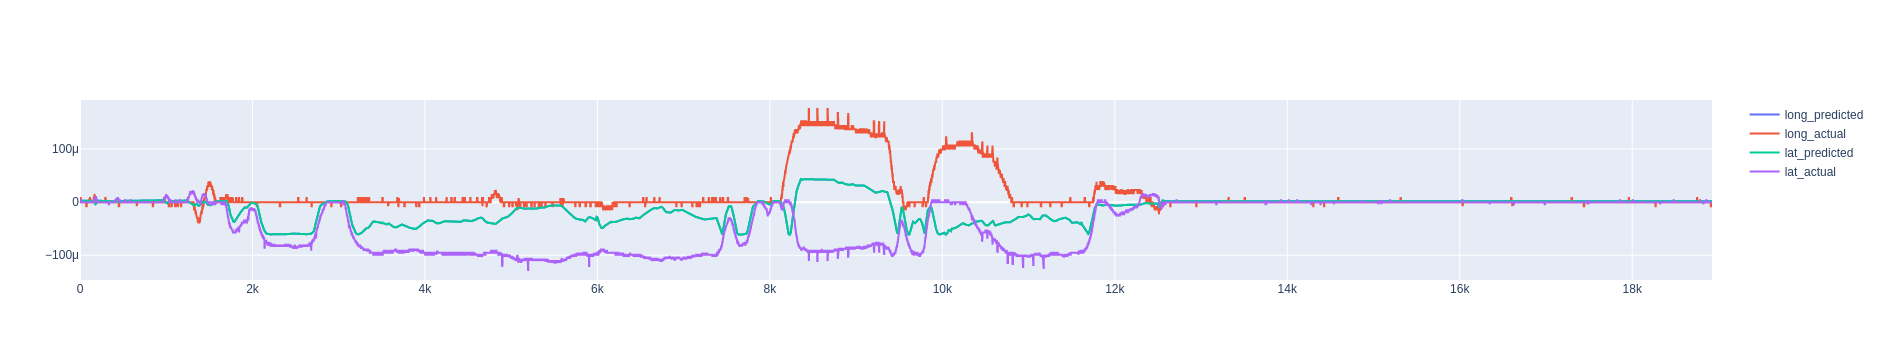

In [205]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_predicted, name="long_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_actual, name="long_actual"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_predicted, name="lat_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_actual, name="lat_actual"))